In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    log_dir=f"{root_dir}/results/logs",
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-22 18:50:22,344 - INFO - Logger initialized for 'TDM_20251122_185022'
2025-11-22 18:50:22,345 - INFO - Using device: cpu


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label").scale(scaler="minmax")

2025-11-22 18:50:22,355 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-22 18:50:23,037 - INFO - Loading dataset into DataFrame
2025-11-22 18:50:37,321 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-22 18:50:52,809 - INFO - ============================================================
2025-11-22 18:50:52,810 - INFO - Preprocessing completed successfully
2025-11-22 18:50:52,810 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-22 18:50:52,811 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-22 18:50:52,811 - INFO - data retention rate: 87.73%
2025-11-22 18:50:52,812 - INFO - ============================================================
2025-11-22 18:50:52,813 - INFO - Optimizing memory usage of the dataset...
2025-11-22 18:50:52,817 - INFO - Initial memory usage: 1067.15 MB
2025-11-22 18:50:53,601 - INFO - Optimized memory usage: 555.81 MB
2025-11-22 18:50:53,601 - INFO - Memory reduction: 511.34 MB (47.92%)
20

In [3]:
dataset, multi_class = full_dataset.subset(size=50000, multi_class=False)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-22 18:51:17,280 - INFO - Subsetting dataset to size: 50000...
2025-11-22 18:51:17,289 - INFO - Class distribution before subsetting:
2025-11-22 18:51:17,290 - INFO -   Class 0: 1528113 samples
2025-11-22 18:51:17,291 - INFO -   Class 1: 414580 samples
2025-11-22 18:51:17,354 - INFO - Subsetted dataset to size: 50000
2025-11-22 18:51:17,406 - INFO - Splitting dataset into training and testing sets...
2025-11-22 18:51:17,453 - INFO - Class distribution before SMOTE:
2025-11-22 18:51:17,454 - INFO -   Class 0.0: 19972 samples
2025-11-22 18:51:17,454 - INFO -   Class 1.0: 20028 samples
2025-11-22 18:51:17,455 - INFO - Class distribution after SMOTE:
2025-11-22 18:51:17,456 - INFO -   Class 0.0: 19972 samples
2025-11-22 18:51:17,456 - INFO -   Class 1.0: 20028 samples


In [10]:
print(X_train.mean(dim=0))
print(X_train.std(dim=0))
print(X_train.min(dim=0))
print(X_train.max(dim=0))

tensor([9.3284e-02, 2.1652e-01, 4.2686e-05, 3.9367e-05, 3.8604e-05, 3.0818e-05,
        8.5959e-03, 5.3367e-03, 9.2109e-03, 1.0730e-02, 1.0778e-01, 1.2177e-02,
        1.1884e-01, 1.0711e-01, 8.5614e-02, 3.3902e-01, 2.0363e-02, 7.7089e-02,
        1.8078e-01, 1.9407e-03, 2.1387e-01, 3.9724e-02, 9.9983e-02, 1.7949e-01,
        8.3543e-03, 9.7652e-02, 1.9373e-02, 3.5511e-02, 6.7092e-02, 7.2782e-03,
        3.1775e-02, 5.0000e-05, 9.9760e-01, 9.6635e-01, 8.9742e-03, 3.6395e-03,
        7.2966e-03, 8.7642e-02, 1.4126e-01, 1.4531e-01, 6.3517e-02, 7.6700e-02,
        3.1775e-02, 1.0000e-04, 3.5400e-01, 3.5940e-01, 6.2900e-02, 5.0000e-05,
        1.0000e-04, 4.3484e-03, 1.0378e-01, 9.2109e-03, 1.1884e-01, 9.9760e-01,
        4.2686e-05, 3.8693e-05, 3.9367e-05, 3.0822e-05, 1.0646e-01, 2.1517e-02,
        3.2415e-05, 9.9997e-01, 1.0025e-03, 5.1139e-04, 1.4993e-03, 7.8876e-04,
        1.6951e-01, 1.5553e-02, 1.7706e-01, 1.6215e-01])
tensor([2.4263e-01, 3.4299e-01, 3.6551e-03, 3.7418e-03, 4.5465e

In [4]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pytorch_attack/MLP_CICIDS2017_70x2_1000.pt")

Input Size: 70, Num Classes: 2


2025-11-22 18:51:17,494 - INFO - Running analysis for PyTorch model: Model on device: cpu


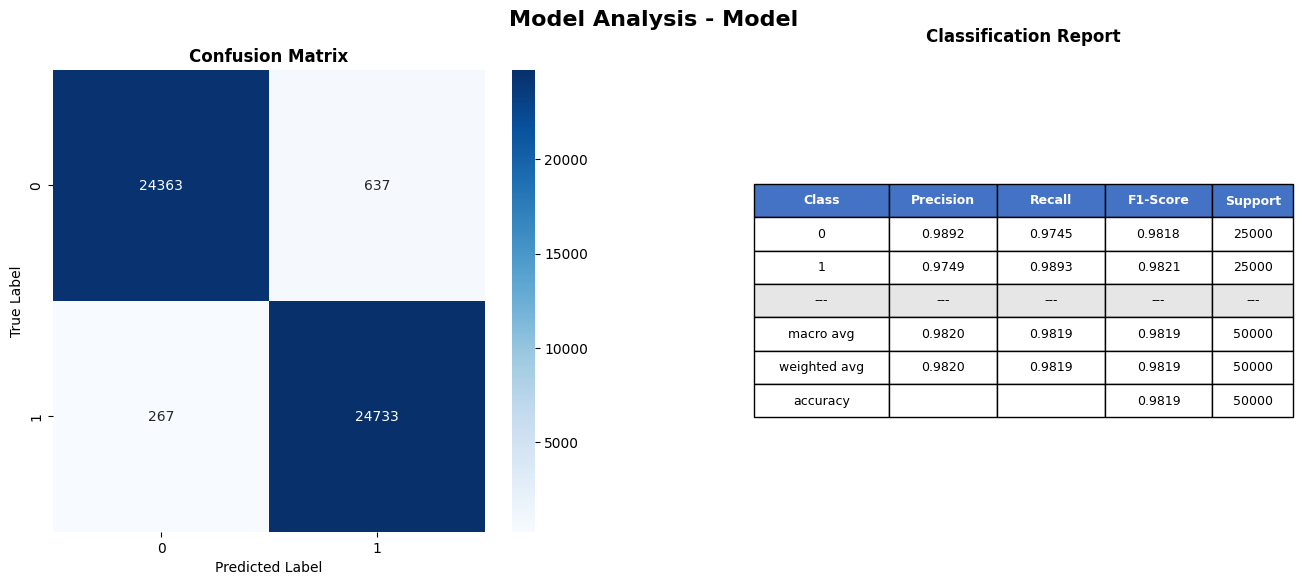

In [5]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)).to(device),
    y_test=torch.vstack((y_train, y_val)).to(device),
    logger=logger,
    save_fig=False,
    plot=True,
    device=device
)

In [6]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[0]

adversarial_attack_input = dataset.features.iloc[attack_indices[random_idx]].values

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).clone().detach().requires_grad_(True)
adversarial_attack_input = adversarial_attack_input.unsqueeze(0).to(device)

print("Original input:", adversarial_attack_input)

Original input: tensor([[1.2207e-03, 8.2857e-01, 1.8202e-05, 2.3979e-05, 2.7752e-05, 1.7690e-05,
         1.3940e-02, 0.0000e+00, 1.2052e-02, 2.1531e-02, 2.2243e-01, 0.0000e+00,
         2.8557e-01, 2.1485e-01, 8.5247e-02, 3.3333e-01, 7.5325e-02, 3.5377e-01,
         8.2833e-01, 3.5833e-07, 8.2833e-01, 2.0667e-01, 5.8745e-01, 8.2833e-01,
         3.9167e-05, 8.2833e-01, 1.3833e-01, 4.8094e-01, 8.2833e-01, 3.0000e-07,
         0.0000e+00, 0.0000e+00, 9.9760e-01, 9.6637e-01, 1.6762e-08, 3.5201e-08,
         0.0000e+00, 1.7502e-01, 3.7456e-01, 3.1657e-01, 1.0016e-01, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.4103e-03, 2.7052e-01, 1.2052e-02, 2.8557e-01, 9.9760e-01,
         1.8202e-05, 2.7816e-05, 2.3979e-05, 1.7690e-05, 1.5259e-05, 3.6011e-03,
         9.3652e-06, 1.0000e+00, 9.9936e-05, 0.0000e+00, 9.9936e-05, 9.9936e-05,
         8.2833e-01, 0.0000e+00, 8.2833e-01, 8.2833e-01]],
       grad_fn=<UnsqueezeBackward0

In [7]:
adversarial_attack_input = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([0]).to(device)

model_mlp.eval()
epsilon = 1e-2

for iter in range(100):
    output = model_mlp(adversarial_attack_input)
    loss = criterion(output, target)

    print(f"Iter {iter}: probs: {torch.softmax(output, dim=1).detach().cpu().numpy()}, Loss: {loss.item()}")

    adversarial_attack_input.grad = None
    loss.backward()

    with torch.no_grad():
        adversarial_attack_input -= epsilon * adversarial_attack_input.grad
        # optional: clamp / project adversarial_attack_input here

    # ensure it's still a leaf with grad enabled for next iter
    adversarial_attack_input.requires_grad_(True)

Iter 0: probs: [[0.26894215 0.7310578 ]], Loss: 1.3132588863372803
Iter 1: probs: [[0.26894218 0.7310578 ]], Loss: 1.3132588863372803
Iter 2: probs: [[0.26894218 0.7310578 ]], Loss: 1.3132588863372803
Iter 3: probs: [[0.2689422 0.7310578]], Loss: 1.3132588863372803
Iter 4: probs: [[0.2689422 0.7310578]], Loss: 1.3132588863372803
Iter 5: probs: [[0.2689422  0.73105776]], Loss: 1.3132587671279907
Iter 6: probs: [[0.2689422  0.73105776]], Loss: 1.3132587671279907
Iter 7: probs: [[0.2689422  0.73105776]], Loss: 1.3132587671279907
Iter 8: probs: [[0.2689422  0.73105776]], Loss: 1.3132587671279907
Iter 9: probs: [[0.2689422  0.73105776]], Loss: 1.3132586479187012
Iter 10: probs: [[0.26894224 0.7310577 ]], Loss: 1.3132586479187012
Iter 11: probs: [[0.26894224 0.7310577 ]], Loss: 1.3132586479187012
Iter 12: probs: [[0.26894224 0.7310577 ]], Loss: 1.3132586479187012
Iter 13: probs: [[0.2689423 0.7310577]], Loss: 1.3132585287094116
Iter 14: probs: [[0.2689423 0.7310577]], Loss: 1.313258409500122